In [1]:
import math
import numpy as np
from lti import drss_matrices, dlsim
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, IterableDataset

In [2]:
n_hidden = 128
nx = 20 # states
nu = 5 # inputs
ny = 2 # outputs
nbr = 10 # number of WH branches
n_hidden = 32 * 10
seq_len = 1000
dtype = "float32"

In [3]:
def nn_fun(x):
    out = x @ w1.transpose() + b1
    out = np.tanh(out)
    out = out @ w2.transpose() + b2
    return out

In [4]:
# Kaiming initialization: divide weights by sqrt(fan_in) and multiply times a gain that compensates
# the squashing effect of the previous non-linearity
w1 = np.random.randn(n_hidden, nbr) / np.sqrt(nbr) * 1.0
b1 = np.random.randn(1, n_hidden) * 1.0
w2 = np.random.randn(nbr, n_hidden) / np.sqrt(n_hidden) * 5/3
b2 = np.random.randn(1, nbr) * 1.0


G1 = drss_matrices(states=nx,
                   inputs=nu,
                   outputs=nbr,
                   strictly_proper=True,
                   mag_range=(0.5, 0.97), phase_range=(0.0, math.pi/2))

G2 = drss_matrices(states=nx,
                   inputs=nbr,
                   outputs=ny,
                   strictly_proper=False,
                   mag_range=(0.5, 0.97), phase_range=(0.0, math.pi/2))

u = np.random.randn(seq_len, nu)
n_skip = 200

# G1
y1 = dlsim(*G1, u)
y1 = (y1 - y1[n_skip:].mean(axis=0)) / (y1[n_skip:].std(axis=0) + 1e-6)

# F
y2 = nn_fun(y1)
y3 = dlsim(*G2, y2)

u = u[n_skip:]
y = y3[n_skip:]


y = (y - y.mean(axis=0)) / (y.std(axis=0) + 1e-6)

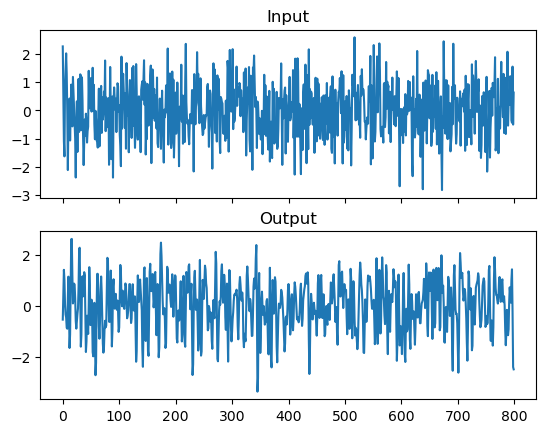

In [5]:
fig, ax = plt.subplots(2,1, sharex=True)
ax[0].set_title("Input")
ax[0].plot(u[:, 0])
ax[1].set_title("Output")
ax[1].plot(y[:, 0]);

In [6]:
class PWHDataset(IterableDataset):
    def __init__(self, nx=50, nu=1, ny=1, nbr=10, seq_len=1024, n_hidden=256, random_order=True,
                 strictly_proper=True, normalize=True, dtype="float32",
                 fixed_system=False, system_seed=None, data_seed=None, **mdlargs):
        super(PWHDataset).__init__()
        self.nx = nx
        self.nu = nu
        self.ny = ny
        self.nbr = nbr
        self.seq_len = seq_len
        self.n_hidden = n_hidden
        self.strictly_proper = strictly_proper
        self.dtype = dtype
        self.normalize = normalize
        self.strictly_proper = strictly_proper
        self.random_order = random_order
        self.mdlargs = mdlargs
        self.system_seed = system_seed
        self.data_seed = data_seed
        self.fixed_system = fixed_system  # same model at each iteration (classical identification)
        self.system_rng = np.random.default_rng(system_seed)  # source of randomness for model generation
        self.data_rng = np.random.default_rng(data_seed)  # source of randomness for model generation

    def sample_system(self):

            
        w1 = self.system_rng.normal(size=(self.n_hidden, self.nbr)) / np.sqrt(self.nbr) * 1.0
        b1 = self.system_rng.normal(size=(1, self.n_hidden)) * 1.0
        w2 = self.system_rng.normal(size=(self.nbr, self.n_hidden)) / np.sqrt(self.n_hidden) * 5/3 # compensates previous tanh 
        b2 = self.system_rng.normal(size=(1, self.nbr)) * 1.0

        G1 = drss_matrices(states=self.system_rng.integers(1, self.nx+1) if self.random_order else self.nx,
                            inputs=self.nu,
                            outputs=self.nbr,
                            strictly_proper=self.strictly_proper,
                            rng = self.system_rng,
                            **self.mdlargs)

        G2 = drss_matrices(states=self.system_rng.integers(1, self.nx+1) if self.random_order else self.nx,
                            inputs=self.nbr,
                            outputs=self.ny,
                            strictly_proper=False, # no delay here (if one is desired, put it in G1)
                            rng = self.system_rng,
                            **self.mdlargs)
        
        return w1, b1, w2, b2, G1, G2
            

    def __iter__(self):

        w1, b1, w2, b2, G1, G2 = self.sample_system()

        # A simple ff neural network
        def nn_fun(x):
            out = x @ w1.transpose() + b1
            out = np.tanh(out)
            out = out @ w2.transpose() + b2
            return out

        n_skip = 200
        while True:  

            u = self.data_rng.normal(size=(self.seq_len + n_skip, self.nu))

            # G1
            y1 = dlsim(*G1, u)
            y1 = (y1 - y1[n_skip:].mean(axis=0)) / (y1[n_skip:].std(axis=0) + 1e-6)

            # F
            y2 = nn_fun(y1)

            # G2
            y3 = dlsim(*G2, y2)

            u = u[n_skip:]
            y = y3[n_skip:]

            if self.normalize:
                y = (y - y.mean(axis=0)) / (y.std(axis=0) + 1e-6)

            u = u.astype(self.dtype)
            y = y.astype(self.dtype)

            if not self.fixed_system: # change system!
                w1, b1, w2, b2, G1, G2 = self.sample_system()

            yield torch.tensor(y), torch.tensor(u)


In [7]:
train_ds = PWHDataset(nx=50, nu=2, ny=3, seq_len=1000, fixed_system=True, mag_range=(0.5, 0.97), phase_range=(0.0, math.pi/2))
train_dl = DataLoader(train_ds, batch_size=32)

In [8]:
batch_y, batch_u = next(iter(train_dl))

In [10]:
batch_u.shape, batch_y.shape

(torch.Size([32, 1000, 2]), torch.Size([32, 1000, 3]))